<a href="https://colab.research.google.com/github/Yenugudharani/Sales-Prediction/blob/main/FraudTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Preview:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2020-06-21 12:14:25  2291163933867244   
1           1   2020-06-21 12:14:33  3573030041201292   
2           2   2020-06-21 12:14:53  3598215285024754   
3           3   2020-06-21 12:15:15  3591919803438423   
4           4   2020-06-21 12:15:17  3526826139003047   

                               merchant        category    amt   first  \
0                 fraud_Kirlin and Sons   personal_care   2.86    Jeff   
1                  fraud_Sporer-Keebler   personal_care  29.84  Joanne   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness  41.28  Ashley   
3                     fraud_Haley Group        misc_pos  60.05   Brian   
4                 fraud_Johnston-Casper          travel   3.19  Nathan   

       last gender                       street  ...      lat      long  \
0   Elliott      M            351 Darlene Green  ...  33.9659  -80.9355   
1  Williams      F             3638 Marsh Uni

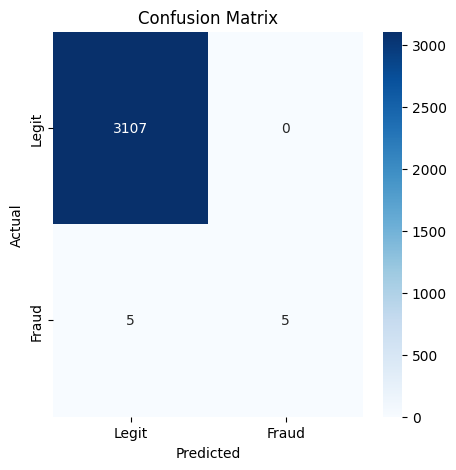

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
file_path = "/fraudTest.csv"
df = pd.read_csv(file_path)

print("Dataset Preview:")
print(df.head())


df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])


df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month
df['year'] = df['trans_date_trans_time'].dt.year
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek

label_encoders = {}
categorical_columns = ['merchant', 'category', 'gender', 'state']

for col in categorical_columns:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))


df['transaction_distance'] = df.apply(lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)


df.drop(columns=['trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 'city', 'job', 'dob', 'trans_num'], inplace=True)


print("\nMissing Values Before Handling:\n", df.isnull().sum())

df.fillna(df.median(numeric_only=True), inplace=True)


df['is_fraud'] = df['is_fraud'].astype(int)


X = df.drop(columns=['is_fraud'])
y = df['is_fraud']


scaler = StandardScaler()
num_cols = ['amt', 'lat', 'long', 'merch_lat', 'merch_long', 'transaction_distance']
X[num_cols] = scaler.fit_transform(X[num_cols])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print("\nTraining Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Unique values in y_train:", y_train.unique())


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Legit", "Fraud"], yticklabels=["Legit", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
